<a href="https://colab.research.google.com/github/a-pujahari/EVA7/blob/main/Session7/EVA7_Assignment7_AdvancedConcepts_AbhinavP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EVA7 - Assignment 7 - Advanced Concepts

Submission by Abhinav Pujahari (abhinavpujahari@gmail.com) - Group 9

## Goals
1. Create a classification NN to train the CIFAR10 dataset to beyond 87% accuracy.
2. Network must have less than 100k parameters
3. One of the layers must use dilated convolution
4. 2 of the layers must use depthwise separable convolution
5. GAP must be used and mapped to the number of classes
6. Use Albumentation library to apply transformations
7. Code must be modular

## Import Dependencies

In [1]:
!pip install albumentations==0.4.6
!pip install torchsummary

In [3]:
import torch
import torchvision
import data_handling as d
import model as m
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ExponentialLR, OneCycleLR, LambdaLR, CosineAnnealingLR
import torch.nn as nn

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## GPU Check

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)


CUDA Available? True


## Data Download, Transformations & Dataset Creation

In [5]:
## Get Dataset Statistics
mean, std = d.return_dataset_statistics()

## Define data transformations
train_transforms, test_transforms = d.albumentation_augmentation(mean, std)

## Download & return transformed datasets
trainset, testset = d.return_datasets(train_transforms, test_transforms)

## Define data loaders
trainloader, testloader = d.return_dataloaders(trainset, testset, cuda)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Visualize Data Examples

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 ship  bird   cat   dog  bird truck truck plane plane  ship truck  frog  bird  bird   dog  frog


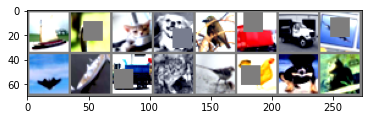

In [6]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:16]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

## Model Summary

In [7]:
from torchsummary import summary

device = torch.device("cuda" if cuda else "cpu")
print(device)
model = m.Net(0.01).to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 15, 30, 30]             405
              ReLU-2           [-1, 15, 30, 30]               0
       BatchNorm2d-3           [-1, 15, 30, 30]              30
           Dropout-4           [-1, 15, 30, 30]               0
            Conv2d-5           [-1, 30, 28, 28]           4,050
              ReLU-6           [-1, 30, 28, 28]               0
       BatchNorm2d-7           [-1, 30, 28, 28]              60
           Dropout-8           [-1, 30, 28, 28]               0
            Conv2d-9           [-1, 60, 14, 14]          16,200
             ReLU-10           [-1, 60, 14, 14]               0
      BatchNorm2d-11           [-1, 60, 14, 14]             120
          Dropout-12           [-1, 60, 14, 14]               0
           Conv2d-13           [-1, 60, 14, 14]          32,400
             ReLU-14           [-1

## Model Training

In [8]:
import train, test
train_acc, train_losses, test_acc, test_losses, lrs = [], [], [], [], []

## Define Optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay=1e-5)

## Define Scheduler
scheduler = OneCycleLR(optimizer, max_lr = 0.015, epochs = 100, steps_per_epoch = len(trainloader))

## Define loss function
criterion = nn.CrossEntropyLoss()

## Define number of epochs and begin training
EPOCHS = 100
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1)
    train.train(model, device, trainloader, train_acc, train_losses, optimizer, scheduler, criterion, lrs)
    test.test(model, device, testloader, test_acc, test_losses, criterion)


EPOCH: 1


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=1.6170250177383423 Batch_id=390 LR=0.00064 Accuracy=41.58: 100%|██████████| 391/391 [00:19<00:00, 20.20it/s]



Test set: Average loss: 0.0104, Accuracy: 5517/10000 (55.17%)

EPOCH: 2


Loss=1.2528544664382935 Batch_id=390 LR=0.00076 Accuracy=52.21: 100%|██████████| 391/391 [00:19<00:00, 20.50it/s]



Test set: Average loss: 0.0092, Accuracy: 6088/10000 (60.88%)

EPOCH: 3


Loss=1.1077592372894287 Batch_id=390 LR=0.00095 Accuracy=56.86: 100%|██████████| 391/391 [00:19<00:00, 20.19it/s]



Test set: Average loss: 0.0082, Accuracy: 6439/10000 (64.39%)

EPOCH: 4


Loss=1.4442808628082275 Batch_id=390 LR=0.00122 Accuracy=59.21: 100%|██████████| 391/391 [00:19<00:00, 20.22it/s]



Test set: Average loss: 0.0076, Accuracy: 6722/10000 (67.22%)

EPOCH: 5


Loss=1.1907039880752563 Batch_id=390 LR=0.00156 Accuracy=61.35: 100%|██████████| 391/391 [00:18<00:00, 20.69it/s]



Test set: Average loss: 0.0069, Accuracy: 7033/10000 (70.33%)

EPOCH: 6


Loss=1.278957486152649 Batch_id=390 LR=0.00198 Accuracy=62.82: 100%|██████████| 391/391 [00:18<00:00, 20.69it/s]



Test set: Average loss: 0.0068, Accuracy: 7034/10000 (70.34%)

EPOCH: 7


Loss=0.8921123743057251 Batch_id=390 LR=0.00245 Accuracy=64.33: 100%|██████████| 391/391 [00:18<00:00, 20.72it/s]



Test set: Average loss: 0.0064, Accuracy: 7180/10000 (71.80%)

EPOCH: 8


Loss=0.8929798007011414 Batch_id=390 LR=0.00298 Accuracy=65.44: 100%|██████████| 391/391 [00:19<00:00, 20.42it/s]



Test set: Average loss: 0.0064, Accuracy: 7207/10000 (72.07%)

EPOCH: 9


Loss=1.0341174602508545 Batch_id=390 LR=0.00357 Accuracy=66.18: 100%|██████████| 391/391 [00:19<00:00, 20.43it/s]



Test set: Average loss: 0.0061, Accuracy: 7395/10000 (73.95%)

EPOCH: 10


Loss=0.9385452270507812 Batch_id=390 LR=0.00420 Accuracy=67.25: 100%|██████████| 391/391 [00:19<00:00, 20.07it/s]



Test set: Average loss: 0.0061, Accuracy: 7325/10000 (73.25%)

EPOCH: 11


Loss=0.9428160786628723 Batch_id=390 LR=0.00487 Accuracy=68.03: 100%|██████████| 391/391 [00:18<00:00, 20.58it/s]



Test set: Average loss: 0.0058, Accuracy: 7440/10000 (74.40%)

EPOCH: 12


Loss=0.7350050210952759 Batch_id=390 LR=0.00558 Accuracy=68.44: 100%|██████████| 391/391 [00:18<00:00, 20.73it/s]



Test set: Average loss: 0.0058, Accuracy: 7457/10000 (74.57%)

EPOCH: 13


Loss=0.7468287348747253 Batch_id=390 LR=0.00630 Accuracy=69.04: 100%|██████████| 391/391 [00:19<00:00, 20.55it/s]



Test set: Average loss: 0.0056, Accuracy: 7541/10000 (75.41%)

EPOCH: 14


Loss=0.7972416877746582 Batch_id=390 LR=0.00705 Accuracy=69.41: 100%|██████████| 391/391 [00:18<00:00, 20.71it/s]



Test set: Average loss: 0.0052, Accuracy: 7782/10000 (77.82%)

EPOCH: 15


Loss=0.9178935289382935 Batch_id=390 LR=0.00780 Accuracy=69.48: 100%|██████████| 391/391 [00:18<00:00, 20.74it/s]



Test set: Average loss: 0.0056, Accuracy: 7608/10000 (76.08%)

EPOCH: 16


Loss=0.9762974977493286 Batch_id=390 LR=0.00855 Accuracy=69.77: 100%|██████████| 391/391 [00:19<00:00, 20.10it/s]



Test set: Average loss: 0.0053, Accuracy: 7661/10000 (76.61%)

EPOCH: 17


Loss=0.8132647275924683 Batch_id=390 LR=0.00930 Accuracy=70.18: 100%|██████████| 391/391 [00:19<00:00, 20.43it/s]



Test set: Average loss: 0.0055, Accuracy: 7609/10000 (76.09%)

EPOCH: 18


Loss=0.7236664295196533 Batch_id=390 LR=0.01003 Accuracy=70.87: 100%|██████████| 391/391 [00:19<00:00, 19.83it/s]



Test set: Average loss: 0.0054, Accuracy: 7655/10000 (76.55%)

EPOCH: 19


Loss=0.8103302717208862 Batch_id=390 LR=0.01073 Accuracy=70.95: 100%|██████████| 391/391 [00:19<00:00, 20.38it/s]



Test set: Average loss: 0.0051, Accuracy: 7794/10000 (77.94%)

EPOCH: 20


Loss=0.9813331365585327 Batch_id=390 LR=0.01140 Accuracy=71.29: 100%|██████████| 391/391 [00:19<00:00, 20.20it/s]



Test set: Average loss: 0.0053, Accuracy: 7706/10000 (77.06%)

EPOCH: 21


Loss=0.7428188920021057 Batch_id=390 LR=0.01203 Accuracy=71.82: 100%|██████████| 391/391 [00:19<00:00, 20.28it/s]



Test set: Average loss: 0.0049, Accuracy: 7863/10000 (78.63%)

EPOCH: 22


Loss=0.7633246183395386 Batch_id=390 LR=0.01262 Accuracy=71.67: 100%|██████████| 391/391 [00:18<00:00, 20.59it/s]



Test set: Average loss: 0.0050, Accuracy: 7754/10000 (77.54%)

EPOCH: 23


Loss=0.9168141484260559 Batch_id=390 LR=0.01315 Accuracy=72.19: 100%|██████████| 391/391 [00:19<00:00, 19.78it/s]



Test set: Average loss: 0.0052, Accuracy: 7770/10000 (77.70%)

EPOCH: 24


Loss=0.6444360017776489 Batch_id=390 LR=0.01363 Accuracy=71.97: 100%|██████████| 391/391 [00:19<00:00, 20.15it/s]



Test set: Average loss: 0.0051, Accuracy: 7780/10000 (77.80%)

EPOCH: 25


Loss=0.9362682104110718 Batch_id=390 LR=0.01404 Accuracy=72.52: 100%|██████████| 391/391 [00:19<00:00, 20.26it/s]



Test set: Average loss: 0.0047, Accuracy: 7955/10000 (79.55%)

EPOCH: 26


Loss=0.8134148716926575 Batch_id=390 LR=0.01438 Accuracy=72.59: 100%|██████████| 391/391 [00:19<00:00, 20.08it/s]



Test set: Average loss: 0.0051, Accuracy: 7789/10000 (77.89%)

EPOCH: 27


Loss=0.853742778301239 Batch_id=390 LR=0.01465 Accuracy=72.47: 100%|██████████| 391/391 [00:19<00:00, 20.17it/s]



Test set: Average loss: 0.0050, Accuracy: 7846/10000 (78.46%)

EPOCH: 28


Loss=0.789745032787323 Batch_id=390 LR=0.01484 Accuracy=72.65: 100%|██████████| 391/391 [00:19<00:00, 20.34it/s]



Test set: Average loss: 0.0053, Accuracy: 7775/10000 (77.75%)

EPOCH: 29


Loss=0.532514214515686 Batch_id=390 LR=0.01496 Accuracy=72.89: 100%|██████████| 391/391 [00:19<00:00, 19.97it/s]



Test set: Average loss: 0.0047, Accuracy: 7940/10000 (79.40%)

EPOCH: 30


Loss=0.7611216902732849 Batch_id=390 LR=0.01500 Accuracy=73.10: 100%|██████████| 391/391 [00:19<00:00, 20.10it/s]



Test set: Average loss: 0.0051, Accuracy: 7807/10000 (78.07%)

EPOCH: 31


Loss=0.7085534334182739 Batch_id=390 LR=0.01499 Accuracy=73.12: 100%|██████████| 391/391 [00:19<00:00, 19.88it/s]



Test set: Average loss: 0.0055, Accuracy: 7657/10000 (76.57%)

EPOCH: 32


Loss=0.6248400211334229 Batch_id=390 LR=0.01497 Accuracy=73.13: 100%|██████████| 391/391 [00:19<00:00, 20.04it/s]



Test set: Average loss: 0.0047, Accuracy: 7957/10000 (79.57%)

EPOCH: 33


Loss=0.8303038477897644 Batch_id=390 LR=0.01493 Accuracy=73.53: 100%|██████████| 391/391 [00:19<00:00, 20.09it/s]



Test set: Average loss: 0.0045, Accuracy: 8009/10000 (80.09%)

EPOCH: 34


Loss=0.7808136940002441 Batch_id=390 LR=0.01488 Accuracy=73.97: 100%|██████████| 391/391 [00:19<00:00, 20.40it/s]



Test set: Average loss: 0.0049, Accuracy: 7957/10000 (79.57%)

EPOCH: 35


Loss=0.8337804675102234 Batch_id=390 LR=0.01481 Accuracy=73.75: 100%|██████████| 391/391 [00:19<00:00, 19.60it/s]



Test set: Average loss: 0.0048, Accuracy: 7891/10000 (78.91%)

EPOCH: 36


Loss=0.8190571069717407 Batch_id=390 LR=0.01473 Accuracy=73.87: 100%|██████████| 391/391 [00:19<00:00, 20.22it/s]



Test set: Average loss: 0.0052, Accuracy: 7678/10000 (76.78%)

EPOCH: 37


Loss=0.845413863658905 Batch_id=390 LR=0.01463 Accuracy=74.27: 100%|██████████| 391/391 [00:19<00:00, 20.43it/s]



Test set: Average loss: 0.0047, Accuracy: 7925/10000 (79.25%)

EPOCH: 38


Loss=0.8599778413772583 Batch_id=390 LR=0.01452 Accuracy=74.52: 100%|██████████| 391/391 [00:18<00:00, 20.66it/s]



Test set: Average loss: 0.0050, Accuracy: 7801/10000 (78.01%)

EPOCH: 39


Loss=0.8802253007888794 Batch_id=390 LR=0.01440 Accuracy=74.34: 100%|██████████| 391/391 [00:18<00:00, 20.74it/s]



Test set: Average loss: 0.0047, Accuracy: 7997/10000 (79.97%)

EPOCH: 40


Loss=0.5409578084945679 Batch_id=390 LR=0.01426 Accuracy=74.57: 100%|██████████| 391/391 [00:18<00:00, 21.00it/s]



Test set: Average loss: 0.0050, Accuracy: 7845/10000 (78.45%)

EPOCH: 41


Loss=0.8145764470100403 Batch_id=390 LR=0.01410 Accuracy=74.57: 100%|██████████| 391/391 [00:18<00:00, 20.58it/s]



Test set: Average loss: 0.0046, Accuracy: 8016/10000 (80.16%)

EPOCH: 42


Loss=0.5945329666137695 Batch_id=390 LR=0.01394 Accuracy=74.93: 100%|██████████| 391/391 [00:18<00:00, 21.00it/s]



Test set: Average loss: 0.0048, Accuracy: 7911/10000 (79.11%)

EPOCH: 43


Loss=0.7674025893211365 Batch_id=390 LR=0.01376 Accuracy=75.23: 100%|██████████| 391/391 [00:18<00:00, 20.72it/s]



Test set: Average loss: 0.0050, Accuracy: 7869/10000 (78.69%)

EPOCH: 44


Loss=0.9683219790458679 Batch_id=390 LR=0.01357 Accuracy=75.13: 100%|██████████| 391/391 [00:18<00:00, 20.61it/s]



Test set: Average loss: 0.0046, Accuracy: 8005/10000 (80.05%)

EPOCH: 45


Loss=0.7368453741073608 Batch_id=390 LR=0.01336 Accuracy=75.33: 100%|██████████| 391/391 [00:19<00:00, 20.53it/s]



Test set: Average loss: 0.0045, Accuracy: 8062/10000 (80.62%)

EPOCH: 46


Loss=0.7625691294670105 Batch_id=390 LR=0.01315 Accuracy=75.55: 100%|██████████| 391/391 [00:18<00:00, 20.91it/s]



Test set: Average loss: 0.0055, Accuracy: 7753/10000 (77.53%)

EPOCH: 47


Loss=0.685743510723114 Batch_id=390 LR=0.01292 Accuracy=75.37: 100%|██████████| 391/391 [00:18<00:00, 21.04it/s]



Test set: Average loss: 0.0046, Accuracy: 8010/10000 (80.10%)

EPOCH: 48


Loss=0.7608854174613953 Batch_id=390 LR=0.01268 Accuracy=75.78: 100%|██████████| 391/391 [00:18<00:00, 21.13it/s]



Test set: Average loss: 0.0041, Accuracy: 8202/10000 (82.02%)

EPOCH: 49


Loss=0.7849591374397278 Batch_id=390 LR=0.01243 Accuracy=75.90: 100%|██████████| 391/391 [00:18<00:00, 21.04it/s]



Test set: Average loss: 0.0042, Accuracy: 8174/10000 (81.74%)

EPOCH: 50


Loss=0.4655318260192871 Batch_id=390 LR=0.01218 Accuracy=76.03: 100%|██████████| 391/391 [00:18<00:00, 21.01it/s]



Test set: Average loss: 0.0051, Accuracy: 7884/10000 (78.84%)

EPOCH: 51


Loss=0.4711760878562927 Batch_id=390 LR=0.01191 Accuracy=76.32: 100%|██████████| 391/391 [00:18<00:00, 21.15it/s]



Test set: Average loss: 0.0044, Accuracy: 8141/10000 (81.41%)

EPOCH: 52


Loss=0.5353828072547913 Batch_id=390 LR=0.01163 Accuracy=76.31: 100%|██████████| 391/391 [00:18<00:00, 21.06it/s]



Test set: Average loss: 0.0041, Accuracy: 8226/10000 (82.26%)

EPOCH: 53


Loss=0.5715699195861816 Batch_id=390 LR=0.01135 Accuracy=76.63: 100%|██████████| 391/391 [00:18<00:00, 21.02it/s]



Test set: Average loss: 0.0042, Accuracy: 8219/10000 (82.19%)

EPOCH: 54


Loss=0.8049017786979675 Batch_id=390 LR=0.01105 Accuracy=76.74: 100%|██████████| 391/391 [00:18<00:00, 21.32it/s]



Test set: Average loss: 0.0041, Accuracy: 8241/10000 (82.41%)

EPOCH: 55


Loss=0.7627498507499695 Batch_id=390 LR=0.01075 Accuracy=77.00: 100%|██████████| 391/391 [00:18<00:00, 21.42it/s]



Test set: Average loss: 0.0041, Accuracy: 8224/10000 (82.24%)

EPOCH: 56


Loss=0.6988294124603271 Batch_id=390 LR=0.01045 Accuracy=77.07: 100%|██████████| 391/391 [00:18<00:00, 21.21it/s]



Test set: Average loss: 0.0040, Accuracy: 8276/10000 (82.76%)

EPOCH: 57


Loss=0.7459193468093872 Batch_id=390 LR=0.01013 Accuracy=77.14: 100%|██████████| 391/391 [00:18<00:00, 21.37it/s]



Test set: Average loss: 0.0042, Accuracy: 8200/10000 (82.00%)

EPOCH: 58


Loss=0.6991762518882751 Batch_id=390 LR=0.00982 Accuracy=77.61: 100%|██████████| 391/391 [00:18<00:00, 21.34it/s]



Test set: Average loss: 0.0040, Accuracy: 8295/10000 (82.95%)

EPOCH: 59


Loss=0.555038332939148 Batch_id=390 LR=0.00949 Accuracy=77.54: 100%|██████████| 391/391 [00:18<00:00, 20.94it/s]



Test set: Average loss: 0.0041, Accuracy: 8208/10000 (82.08%)

EPOCH: 60


Loss=0.5834019184112549 Batch_id=390 LR=0.00917 Accuracy=78.01: 100%|██████████| 391/391 [00:18<00:00, 21.40it/s]



Test set: Average loss: 0.0039, Accuracy: 8333/10000 (83.33%)

EPOCH: 61


Loss=0.6289770603179932 Batch_id=390 LR=0.00884 Accuracy=78.61: 100%|██████████| 391/391 [00:18<00:00, 20.80it/s]



Test set: Average loss: 0.0040, Accuracy: 8324/10000 (83.24%)

EPOCH: 62


Loss=0.6617144346237183 Batch_id=390 LR=0.00851 Accuracy=78.08: 100%|██████████| 391/391 [00:18<00:00, 21.20it/s]



Test set: Average loss: 0.0043, Accuracy: 8157/10000 (81.57%)

EPOCH: 63


Loss=0.6125211119651794 Batch_id=390 LR=0.00817 Accuracy=78.35: 100%|██████████| 391/391 [00:18<00:00, 21.07it/s]



Test set: Average loss: 0.0038, Accuracy: 8364/10000 (83.64%)

EPOCH: 64


Loss=0.6077973246574402 Batch_id=390 LR=0.00784 Accuracy=78.57: 100%|██████████| 391/391 [00:18<00:00, 20.86it/s]



Test set: Average loss: 0.0038, Accuracy: 8394/10000 (83.94%)

EPOCH: 65


Loss=0.767959713935852 Batch_id=390 LR=0.00750 Accuracy=79.15: 100%|██████████| 391/391 [00:18<00:00, 20.75it/s]



Test set: Average loss: 0.0039, Accuracy: 8355/10000 (83.55%)

EPOCH: 66


Loss=0.7602676153182983 Batch_id=390 LR=0.00716 Accuracy=79.18: 100%|██████████| 391/391 [00:18<00:00, 20.94it/s]



Test set: Average loss: 0.0038, Accuracy: 8387/10000 (83.87%)

EPOCH: 67


Loss=0.8681639432907104 Batch_id=390 LR=0.00683 Accuracy=79.44: 100%|██████████| 391/391 [00:19<00:00, 20.33it/s]



Test set: Average loss: 0.0036, Accuracy: 8419/10000 (84.19%)

EPOCH: 68


Loss=0.6135698556900024 Batch_id=390 LR=0.00649 Accuracy=79.68: 100%|██████████| 391/391 [00:18<00:00, 20.80it/s]



Test set: Average loss: 0.0037, Accuracy: 8450/10000 (84.50%)

EPOCH: 69


Loss=0.5220605134963989 Batch_id=390 LR=0.00616 Accuracy=79.90: 100%|██████████| 391/391 [00:18<00:00, 20.91it/s]



Test set: Average loss: 0.0037, Accuracy: 8425/10000 (84.25%)

EPOCH: 70


Loss=0.5678795576095581 Batch_id=390 LR=0.00583 Accuracy=80.24: 100%|██████████| 391/391 [00:18<00:00, 20.64it/s]



Test set: Average loss: 0.0036, Accuracy: 8476/10000 (84.76%)

EPOCH: 71


Loss=0.392962247133255 Batch_id=390 LR=0.00550 Accuracy=80.22: 100%|██████████| 391/391 [00:18<00:00, 21.45it/s]



Test set: Average loss: 0.0036, Accuracy: 8485/10000 (84.85%)

EPOCH: 72


Loss=0.7164026498794556 Batch_id=390 LR=0.00518 Accuracy=80.62: 100%|██████████| 391/391 [00:18<00:00, 20.84it/s]



Test set: Average loss: 0.0035, Accuracy: 8483/10000 (84.83%)

EPOCH: 73


Loss=0.5369387865066528 Batch_id=390 LR=0.00486 Accuracy=81.07: 100%|██████████| 391/391 [00:18<00:00, 21.07it/s]



Test set: Average loss: 0.0034, Accuracy: 8536/10000 (85.36%)

EPOCH: 74


Loss=0.5108539462089539 Batch_id=390 LR=0.00455 Accuracy=81.06: 100%|██████████| 391/391 [00:18<00:00, 21.00it/s]



Test set: Average loss: 0.0035, Accuracy: 8515/10000 (85.15%)

EPOCH: 75


Loss=0.5650990605354309 Batch_id=390 LR=0.00425 Accuracy=81.34: 100%|██████████| 391/391 [00:19<00:00, 20.58it/s]



Test set: Average loss: 0.0034, Accuracy: 8548/10000 (85.48%)

EPOCH: 76


Loss=0.457538366317749 Batch_id=390 LR=0.00395 Accuracy=81.76: 100%|██████████| 391/391 [00:18<00:00, 21.18it/s]



Test set: Average loss: 0.0034, Accuracy: 8557/10000 (85.57%)

EPOCH: 77


Loss=0.6026840209960938 Batch_id=390 LR=0.00365 Accuracy=81.69: 100%|██████████| 391/391 [00:18<00:00, 20.85it/s]



Test set: Average loss: 0.0033, Accuracy: 8614/10000 (86.14%)

EPOCH: 78


Loss=0.7085944414138794 Batch_id=390 LR=0.00337 Accuracy=81.88: 100%|██████████| 391/391 [00:18<00:00, 21.09it/s]



Test set: Average loss: 0.0033, Accuracy: 8658/10000 (86.58%)

EPOCH: 79


Loss=0.5394017100334167 Batch_id=390 LR=0.00309 Accuracy=82.47: 100%|██████████| 391/391 [00:18<00:00, 21.43it/s]



Test set: Average loss: 0.0033, Accuracy: 8633/10000 (86.33%)

EPOCH: 80


Loss=0.6198055744171143 Batch_id=390 LR=0.00282 Accuracy=82.55: 100%|██████████| 391/391 [00:18<00:00, 21.68it/s]



Test set: Average loss: 0.0033, Accuracy: 8634/10000 (86.34%)

EPOCH: 81


Loss=0.6339340806007385 Batch_id=390 LR=0.00256 Accuracy=82.62: 100%|██████████| 391/391 [00:18<00:00, 21.23it/s]



Test set: Average loss: 0.0032, Accuracy: 8673/10000 (86.73%)

EPOCH: 82


Loss=0.4465164542198181 Batch_id=390 LR=0.00232 Accuracy=82.91: 100%|██████████| 391/391 [00:18<00:00, 21.17it/s]



Test set: Average loss: 0.0033, Accuracy: 8671/10000 (86.71%)

EPOCH: 83


Loss=0.5279701948165894 Batch_id=390 LR=0.00208 Accuracy=83.22: 100%|██████████| 391/391 [00:18<00:00, 20.66it/s]



Test set: Average loss: 0.0033, Accuracy: 8666/10000 (86.66%)

EPOCH: 84


Loss=0.42224639654159546 Batch_id=390 LR=0.00185 Accuracy=83.39: 100%|██████████| 391/391 [00:19<00:00, 20.41it/s]



Test set: Average loss: 0.0032, Accuracy: 8694/10000 (86.94%)

EPOCH: 85


Loss=0.5410781502723694 Batch_id=390 LR=0.00164 Accuracy=83.58: 100%|██████████| 391/391 [00:18<00:00, 20.63it/s]



Test set: Average loss: 0.0032, Accuracy: 8677/10000 (86.77%)

EPOCH: 86


Loss=0.459076464176178 Batch_id=390 LR=0.00143 Accuracy=83.88: 100%|██████████| 391/391 [00:18<00:00, 20.86it/s]



Test set: Average loss: 0.0031, Accuracy: 8681/10000 (86.81%)

EPOCH: 87


Loss=0.45929503440856934 Batch_id=390 LR=0.00124 Accuracy=83.72: 100%|██████████| 391/391 [00:18<00:00, 20.85it/s]



Test set: Average loss: 0.0031, Accuracy: 8665/10000 (86.65%)

EPOCH: 88


Loss=0.4020029902458191 Batch_id=390 LR=0.00106 Accuracy=84.41: 100%|██████████| 391/391 [00:19<00:00, 20.50it/s]



Test set: Average loss: 0.0031, Accuracy: 8707/10000 (87.07%)

EPOCH: 89


Loss=0.5243881940841675 Batch_id=390 LR=0.00090 Accuracy=84.19: 100%|██████████| 391/391 [00:19<00:00, 20.09it/s]



Test set: Average loss: 0.0031, Accuracy: 8686/10000 (86.86%)

EPOCH: 90


Loss=0.37313714623451233 Batch_id=390 LR=0.00074 Accuracy=84.72: 100%|██████████| 391/391 [00:18<00:00, 20.69it/s]



Test set: Average loss: 0.0031, Accuracy: 8692/10000 (86.92%)

EPOCH: 91


Loss=0.456688791513443 Batch_id=390 LR=0.00060 Accuracy=84.52: 100%|██████████| 391/391 [00:19<00:00, 20.25it/s]



Test set: Average loss: 0.0031, Accuracy: 8692/10000 (86.92%)

EPOCH: 92


Loss=0.5016354918479919 Batch_id=390 LR=0.00048 Accuracy=84.56: 100%|██████████| 391/391 [00:19<00:00, 20.13it/s]



Test set: Average loss: 0.0030, Accuracy: 8719/10000 (87.19%)

EPOCH: 93


Loss=0.3337455093860626 Batch_id=390 LR=0.00037 Accuracy=84.79: 100%|██████████| 391/391 [00:19<00:00, 20.46it/s]



Test set: Average loss: 0.0031, Accuracy: 8705/10000 (87.05%)

EPOCH: 94


Loss=0.36742058396339417 Batch_id=390 LR=0.00027 Accuracy=84.91: 100%|██████████| 391/391 [00:18<00:00, 20.68it/s]



Test set: Average loss: 0.0030, Accuracy: 8741/10000 (87.41%)

EPOCH: 95


Loss=0.4263143539428711 Batch_id=390 LR=0.00019 Accuracy=85.05: 100%|██████████| 391/391 [00:19<00:00, 20.46it/s]



Test set: Average loss: 0.0031, Accuracy: 8729/10000 (87.29%)

EPOCH: 96


Loss=0.3605019450187683 Batch_id=390 LR=0.00012 Accuracy=85.17: 100%|██████████| 391/391 [00:18<00:00, 20.74it/s]



Test set: Average loss: 0.0030, Accuracy: 8740/10000 (87.40%)

EPOCH: 97


Loss=0.4268925189971924 Batch_id=390 LR=0.00007 Accuracy=84.91: 100%|██████████| 391/391 [00:19<00:00, 20.47it/s]



Test set: Average loss: 0.0030, Accuracy: 8734/10000 (87.34%)

EPOCH: 98


Loss=0.5031083822250366 Batch_id=390 LR=0.00003 Accuracy=85.01: 100%|██████████| 391/391 [00:18<00:00, 20.58it/s]



Test set: Average loss: 0.0030, Accuracy: 8723/10000 (87.23%)

EPOCH: 99


Loss=0.4575904309749603 Batch_id=390 LR=0.00001 Accuracy=85.08: 100%|██████████| 391/391 [00:19<00:00, 20.15it/s]



Test set: Average loss: 0.0031, Accuracy: 8711/10000 (87.11%)

EPOCH: 100


Loss=0.35311394929885864 Batch_id=390 LR=0.00000 Accuracy=84.94: 100%|██████████| 391/391 [00:19<00:00, 20.08it/s]



Test set: Average loss: 0.0031, Accuracy: 8724/10000 (87.24%)



## Plot Loss & Accuracy Graphs

Text(0.5, 1.0, 'Test Accuracy')

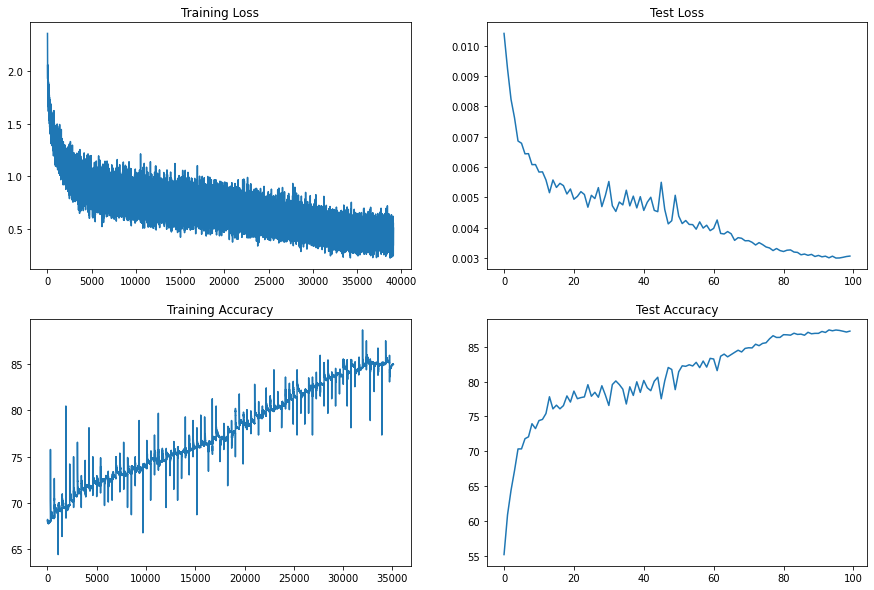

In [9]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Accuracy per class

In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of plane : 88 %
Accuracy of   car : 93 %
Accuracy of  bird : 71 %
Accuracy of   cat : 77 %
Accuracy of  deer : 93 %
Accuracy of   dog : 79 %
Accuracy of  frog : 93 %
Accuracy of horse : 86 %
Accuracy of  ship : 94 %
Accuracy of truck : 94 %
